# Intro to neural networks

First let's import the modules we need:

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as pp
from sklearn.linear_model import LinearRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.



Here I'm creating 50 noisy "linear" points. The function I'm using is
$$ y = 0.4x + 0.2 + \epsilon$$

where $\epsilon \sim N(0,0.05)$

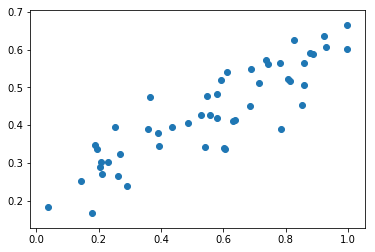

In [2]:
numpy.random.seed(142857)

x = numpy.random.uniform(0, 1, (50,1))
y = x * 0.4 + 0.2 + numpy.random.normal(0,.05, (50,1))

pp.scatter(x,y)
pp.show()

Now I'm using sklearn's `LinearRegression` to fit the data as a line $ax+b$, and I retrieve the approximated $a$ and $b$ via `coef_` and `intercept_`.

a*x+b, a = 0.417047133951 , b = 0.200860149903


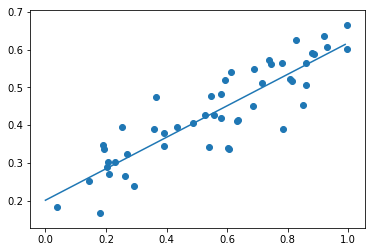

In [3]:
regression = LinearRegression()
regression.fit(x,y)
a,b = regression.coef_[0,0], regression.intercept_[0]

print("a*x+b,","a =",a, ", b =",b)

# plot the data
pp.scatter(x,y)
# plot what this line looks like
line = numpy.arange(0,1,0.01)
pp.plot(line, list(map(lambda x: x*a+b, line)))
pp.show()

### Approximating non-linear functions
Now I'm creating some data that definitely isn't linear. You'll see that a linear regression fails to really capture the factors of variation of the data.

a*x+b, a = -2.83988591344 , b = 1.29704175169


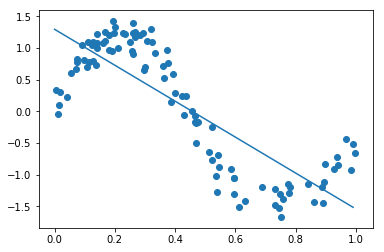

In [4]:
x = numpy.random.uniform(0, 1, (100,1))
y = numpy.sin(x*7) + x * 0.4 + 0.2 + numpy.random.normal(0,.2, (100,1)) - x**2 * 2

regression = LinearRegression()
regression.fit(x,y)
a,b = regression.coef_[0,0], regression.intercept_[0]
print("a*x+b,","a =",a, ", b =",b)

pp.scatter(x,y)
line = numpy.arange(0,1,0.01)
pp.plot(line, list(map(lambda x: x*a+b, line)))
pp.show()

#### Fitting a neural network
Let's try to fit a 2 layer neural network instead, and train it for 150 epochs.

In [5]:
# These are the hyperparameters
num_epochs = 150
num_hidden = 16
learning_rate = 0.05
L2 = keras.regularizers.l2(1e-6)
optimizer = keras.optimizers.SGD(lr=learning_rate)

# building the model
model = Sequential()
model.add(Dense(num_hidden, activation='relu', kernel_regularizer=L2, input_shape=(1,)))
model.add(Dense(num_hidden, activation='relu', kernel_regularizer=L2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',   # now I'm using the Mean Squared Error, (y-yp)^2
              optimizer=optimizer,
              metrics=['accuracy'])
# training the model, this may take a while for larger datasets/models or more epochs
history = model.fit(x, y, batch_size=4, epochs=num_epochs, verbose=0)
ypred = model.predict(x)

Now let's draw what the neural network predicts (in green) vs the actual dataset (in blue)

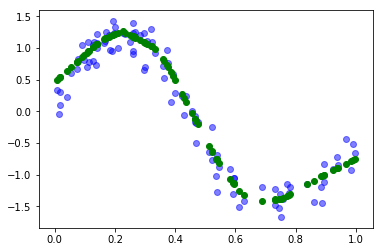

In [6]:
pp.scatter(x,y,color='blue',alpha=0.5)
pp.scatter(x,ypred,color='green')
pp.show()

That's a better, but it could look nicer. Try playing around with the hyperparameters to see if you can improve the model!

# Debugging neural networks
It's always useful when training a neural net to look at what happened during training.

### Looking at the loss
For example, here I'm plotting the "training loss", the mean squared error of the training examples in this case, as a function of the progress of the neural network's training (the number of epochs done).

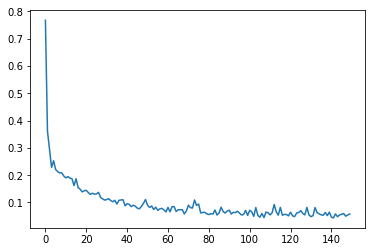

In [7]:
pp.plot(history.history['loss'])
pp.show()

Here we see that the training loss reaches a plateau that isn't 0. Most of the time this can mean one of two things:
- The neural network's learning rate is too large, it is stuck.
- The neural network is using all its capacity, and would require more neurons, or more layers, to reach a lower loss.


In general if the training error is still decreasing, it means that:
- You could train for longer
- You could have a higher learning rate

### Having a validation set
Having validation data (that the neural network does not train on), on top of test data, is essential. It helps you judge whether your model is overfitting (learning by heart) its training data or not.

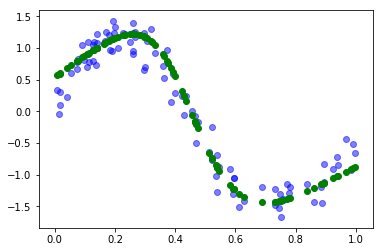

In [8]:
# let's keep 25 examples as our validation set
train_x = x[:75] # array[:N] takes a slice from 0 (inclusively) to N (exclusively)
train_y = y[:75]
valid_x = x[75:] # array[N:] takes a slice from N (inclusively) until the end
valid_y = y[75:]

model = Sequential()
model.add(Dense(num_hidden, activation='tanh', kernel_regularizer=L2, input_shape=(1,)))
model.add(Dense(num_hidden, activation='tanh', kernel_regularizer=L2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',   # now I'm using the Mean Squared Error, (y-yp)^2
              optimizer=optimizer,
              metrics=['accuracy'])
# training the model, this may take a while for larger datasets/models or more epochs
history = model.fit(train_x, train_y, 4, num_epochs, verbose=0, validation_data=(valid_x, valid_y))
ypred = model.predict(x)

pp.scatter(x,y,color='blue',alpha=0.5)
pp.scatter(x,ypred,color='green')
pp.show()

Let's plot the loss again, but this time both the training and validation losses:

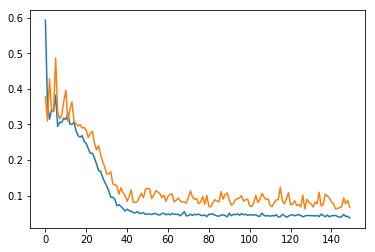

In [9]:
pp.plot(history.history['loss'])
pp.plot(history.history['val_loss'])
pp.show()

We see that they're both very similar, which is great!

Now, just to illustrate the overfitting scenario, let's train with only 5 examples and validate with the remaining 5 examples.

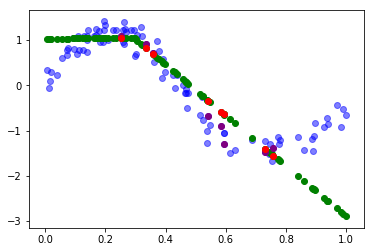

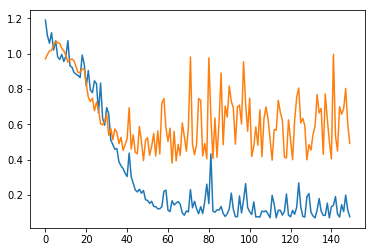

In [10]:
train_x = x[:8]
train_y = y[:8]
valid_x = x[8:]
valid_y = y[8:]

model = Sequential()
model.add(Dense(num_hidden, activation='relu', kernel_regularizer=L2, input_shape=(1,)))
model.add(Dense(num_hidden, activation='relu', kernel_regularizer=L2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',   # now I'm using the Mean Squared Error, (y-yp)^2
              optimizer=optimizer,
              metrics=['accuracy'])
# training the model, this may take a while for larger datasets/models or more epochs
history = model.fit(train_x, train_y, 4, num_epochs, verbose=0, validation_data=(valid_x, valid_y))
ypred = model.predict(x)

pp.scatter(x,y,color='blue',alpha=0.5)
pp.scatter(x,ypred,color='green')
pp.scatter(train_x,train_y,color='purple')
pp.scatter(train_x,model.predict(train_x),color='red')
pp.show()

pp.plot(history.history['loss'])
pp.plot(history.history['val_loss'])
pp.show()

We can see that:
- in the first plot, the 5 training points (in red) are fit quite well (their target is in purple), but the rest isn't.
- in the second plot, the validation error (in green) is much higher than the training error (in blue)

This is overfitting!


## Making neural networks robust with regularization

You may have noticed that I have sneaked in the previous model that we use something called "L2" regularization. This regularization imposes a loss on the 2-norm of the weights, thus forcing them to remain small. This somewhat prevents the neural network from overfitting.

The higher the factor is (here I used $10^{-6}$, or `1e-6`), the smaller the weights are forced to be. Usually less than 0.1 is good, often around `1e-3` or `1e-4`.


In [11]:
L2 = keras.regularizers.l2(1e-6)
model = Sequential()
# ...
model.add(Dense(num_hidden, activation='tanh', input_shape=(10,),
                # the regularizer:
                kernel_regularizer=L2))
# ...

Another useful regularizer, **especially in the low-data regime**, is one called Dropout.

Dropout randomly disables nodes in a neural network with some probability $p$ (usually people use $p=0.5$). This forces the neural network not to learn to rely on a particular node, and helps it generalize better.

In [12]:
# this can go with the imports in the first cell
from keras.layers import Dropout
# ...
# add dropout between two layers
model.add(Dropout(0.5))

A full example here. We're only giving 15 examples to our neural network now, but we're going to use Dropout.

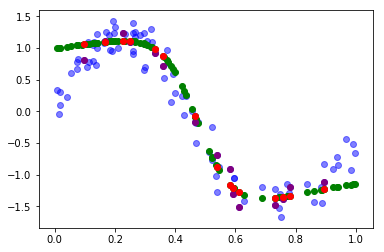

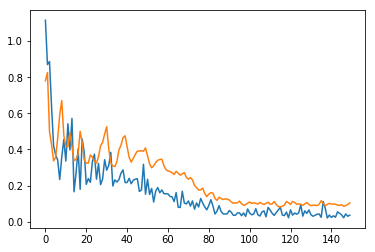

In [13]:
train_x = x[:15]
train_y = y[:15]
valid_x = x[15:]
valid_y = y[15:]

# training with Dropout usually requires a more powerful optimizer,
# here we use Adam (Adaptative Momentum)
optimizer = keras.optimizers.Adam(lr=0.015)

model = Sequential()
model.add(Dense(num_hidden, activation='tanh', kernel_regularizer=L2, input_shape=(1,)))
model.add(Dropout(0.5))
model.add(Dense(num_hidden, activation='tanh', kernel_regularizer=L2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse',   # now I'm using the Mean Squared Error, (y-yp)^2
              optimizer=optimizer,
              metrics=['accuracy'])
# training the model, this may take a while for larger datasets/models or more epochs
history = model.fit(train_x, train_y, 4, num_epochs, verbose=0, validation_data=(valid_x, valid_y))
ypred = model.predict(x)

pp.scatter(x,y,color='blue',alpha=0.5)
pp.scatter(x,ypred,color='green')
pp.scatter(train_x,train_y,color='purple')
pp.scatter(train_x,model.predict(train_x),color='red')
pp.show()

pp.plot(history.history['loss'])
pp.plot(history.history['val_loss'])
pp.show()

We see that the function that the model learns isn't too bad, and that the validation loss isn't too far away from the training loss.

## Training a neural network on real data
MNIST is one of the most iconic datasets of the neural network community. Here's how to load it:

(60000, 784) (60000, 10)


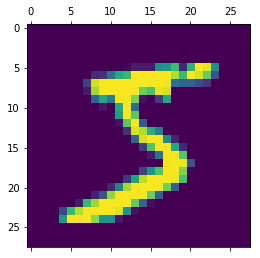

In [14]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# here's what the data looks like:
print(x_train.shape, y_train.shape)
pp.matshow(x_train[0].reshape((28,28)))
pp.show()

MNIST is a classification dataset of handwritten digits, with 10 classes (the 10 digits). Here's how to train a linear softmax classifier using keras. 

Since we want to train a classifier, we want the last output layer (in the case of this classifier, the only layer) to output a probability for each class, i.e. a vector of 10 numbers between 0 and 1. Since each example $x$ can only be a member of a single class, we want to predict a [categorical probability distsribution](https://en.wikipedia.org/wiki/Categorical_distribution) (i.e. a vector between 0 and 1 that sums to 1). 

It is possible to obtain such a vector using the softmax activation function:
$$ softmax(\mathbf{x})_j = \frac{e^{x_j}}{\sum_i e^{x_i}} $$

We must also use a more adapted loss function. The mean squared error would still work, but there are more effective loss functions for classification. Notably, people almost always use [categorical crossentropy](https://en.wikipedia.org/wiki/Cross_entropy).
$$ \sum_i y_i^T\log f(x_i)$$
Where $f(x_i)$ is a softmax-ed vector and $y_i$ is a [one-hot](https://en.wikipedia.org/wiki/One-hot) vector, i.e. [0,...,0,1,0,...,0].

In [15]:
model = Sequential()
model.add(Dense(10, activation='softmax', kernel_regularizer=L2, input_shape=(784,)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.8)

Train on 11999 samples, validate on 48001 samples
Epoch 1/10
11999/11999 [==============================] - 1s - loss: 0.8209 - acc: 0.8022 - val_loss: 0.5104 - val_acc: 0.8670
Epoch 2/10
11999/11999 [==============================] - 1s - loss: 0.4120 - acc: 0.8952 - val_loss: 0.4098 - val_acc: 0.8878
Epoch 3/10
11999/11999 [==============================] - 1s - loss: 0.3458 - acc: 0.9088 - val_loss: 0.3725 - val_acc: 0.8966
Epoch 4/10
11999/11999 [==============================] - 1s - loss: 0.3134 - acc: 0.9175 - val_loss: 0.3528 - val_acc: 0.9018
Epoch 5/10
11999/11999 [==============================] - 1s - loss: 0.2916 - acc: 0.9213 - val_loss: 0.3424 - val_acc: 0.9039
Epoch 6/10
11999/11999 [==============================] - 2s - loss: 0.2771 - acc: 0.9240 - val_loss: 0.3344 - val_acc: 0.9064
Epoch 7/10
11999/11999 [==============================] - 1s - loss: 0.2646 - acc: 0.9262 - val_loss: 0.3293 - val_acc: 0.9069
Epoch 8/10
11999/11999 [==============================] - 1s 

As you can see, with a simple linear softmax classifier, we can get a pretty good validation accuracy of 91%. A neural network can do better! (you should be able to get 96-98% at least)

Training a neural network model is left as an exercice to the reader.

In [16]:
model = Sequential()
model.add(Dense(32, activation='relu', kernel_regularizer=L2, input_shape=(784,)))
# ...
# complete me!

**Extra challenge, train your model on MNIST using only 1000 examples.**

In [17]:
small_train_x = x_train[:1000]
small_train_y = y_train[:1000]
small_valid_x = x_train[1000:]
small_valid_y = y_train[1000:]